In [1]:
import itertools
import math
import multiprocessing as mp
import os
import platform
import random
import sys
import time
from multiprocessing import shared_memory
from pathlib import Path

import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

# plt.rcParams['figure.dpi'] = 300

In [2]:
IMAGE_DIR = Path("./data")

cam_1_images = sorted(IMAGE_DIR.glob("cam_1*.jpg"))
cam_2_images = sorted(IMAGE_DIR.glob("cam_2*.jpg"))

# Pre-processing

## Take Live Capture
This section is only used for assessment

In [3]:
from datetime import datetime
from typing import Optional


def decode_fourcc(v):
    v = int(v)
    return "".join([chr((v >> 8*i) & 0xFF) for i in range(4)])

def open_camera(device=0, width=4096, height=2160, fps=30):
    # Pick a backend that tends to expose more camera controls on each OS
    if sys.platform.startswith("linux"):
        backend = cv2.CAP_V4L2
    elif sys.platform == "win32":
        # Try DirectShow first. If you have issues, try CAP_MSMF instead.
        backend = cv2.CAP_MSMF
    elif sys.platform == "darwin":
        backend = cv2.CAP_AVFOUNDATION
    else:
        backend = 0

    cap = cv2.VideoCapture(device, 0)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open camera {device} with backend {backend}")

    print(f"Backend: {cap.getBackendName() if hasattr(cap, 'getBackendName') else backend}")

    chosen_fourcc = None
    ok = cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"MJPG"))
    # Some backends return False but still accept after a read; we’ll still try.
    actual_fcc = decode_fourcc(cap.get(cv2.CAP_PROP_FOURCC))
    if actual_fcc.strip("\x00") in ("MJPG",):
        chosen_fourcc = actual_fcc
        print(f"Selected FOURCC: {chosen_fourcc}")
        
    if chosen_fourcc is None:
        chosen_fourcc = decode_fourcc(cap.get(cv2.CAP_PROP_FOURCC))
        print(f"Could not set preferred Format, using: {chosen_fourcc or 'Unknown'}")

    # Request resolution and fps
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    cap.set(cv2.CAP_PROP_FPS, fps)

    # Give the driver a moment, and grab a few frames to let it settle
    for _ in range(5):
        cap.read()
        time.sleep(0.02)

    actual_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    actual_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    actual_fps = cap.get(cv2.CAP_PROP_FPS) or 0
    actual_fcc = decode_fourcc(cap.get(cv2.CAP_PROP_FOURCC))
    print(f"Requested: {width}x{height}@{fps} | Got: {actual_w}x{actual_h}@{actual_fps:.2f} format={actual_fcc or 'Unknown'}")

    # Optional: if 4096x2160 not granted, try UHD 3840x2160 (more common)
    if (actual_w, actual_h) != (width, height):
        print("Did not get 4096x2160. Trying 3840x2160...")
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 3840)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 2160)
        for _ in range(5):
            cap.read()
            time.sleep(0.02)
        actual_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        actual_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        print(f"After fallback: {actual_w}x{actual_h}")

    cap.set(cv2.CAP_PROP_AUTOFOCUS, 1)
    cap.set(cv2.CAP_PROP_AUTO_WB, 1)

    return cap

def capture_one_png(device, path=Optional[str], width=4096, height=2160, fps=30):
    cap = open_camera(device, width, height, fps)

    # Warm up a few frames so auto-exposure/white balance can settle
    for _ in range(10):
        cap.read()
        time.sleep(0.02)

    ok, frame = cap.read()
    if not ok or frame is None:
        cap.release()
        raise RuntimeError("Failed to capture a frame")

    ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    if path is None:
        out_dir = Path(".")
        base = "cam_5"
    else:
        p = Path(path)
        if p.suffix.lower() == ".jpg":
            # Use the provided filename's stem as the base, keep its directory
            out_dir = p.parent if p.parent.as_posix() != "" else Path(".")
            base = p.stem
        else:
            # Treat path as a directory
            out_dir = p
            base = "cam_5"

    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"{base}_{ts}.jpg"

    # Save lossless for best quality
    cv2.imwrite(str(out_path), frame, [cv2.IMWRITE_PNG_COMPRESSION, 3])
    print(f"Saved: {out_path.resolve()}  |  shape={frame.shape}")

    cap.release()

    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# device can be an index (0,1,2...) or on Linux a path like '/dev/video2'
# image = capture_one_png(2, path="./data", width=4096, height=2160, fps=30)

## Filtering Part
If you want to test data from pre-captured data. Just load the file

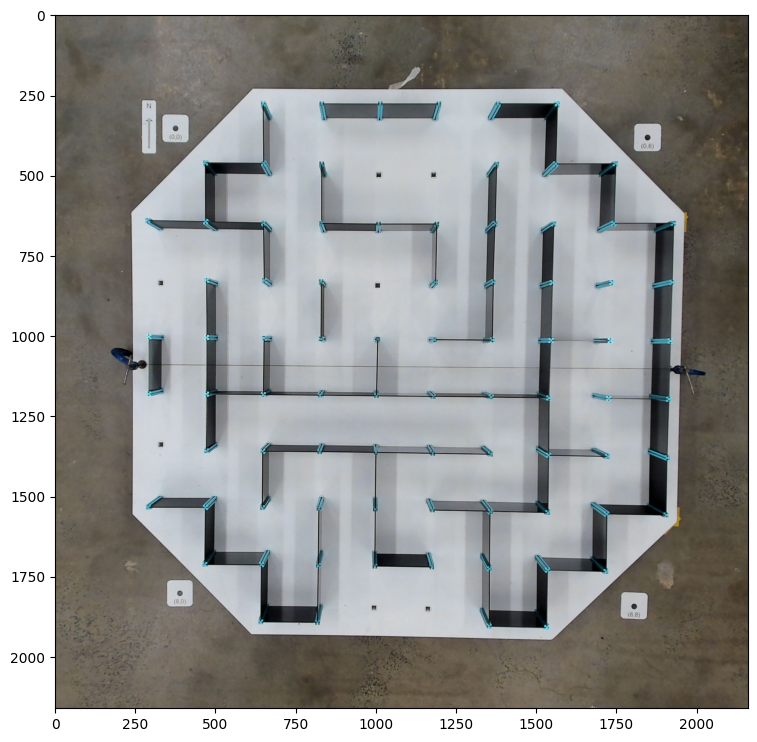

In [4]:
# image_file = cam_2_images[random.randint(0, len(cam_2_images) - 1)]
image = cv2.imread("data/cam_5_99.jpg", cv2.IMREAD_COLOR_RGB)

if image.shape[0] == 1080:
    N = 1080
    map_image = image[:, 450: 450+N]
elif image.shape[0] == 2160:
    N = 2160
    map_image = image[:, 1150: 1150+N]
plt.figure(figsize=(9, 9))
plt.imshow(map_image)
plt.show()

## Pivot Detection
Finding 4 Stickers that is sticked on 4 corners of the maze

[(1804, 1842), (1846, 381), (375, 352), (388, 1802)]


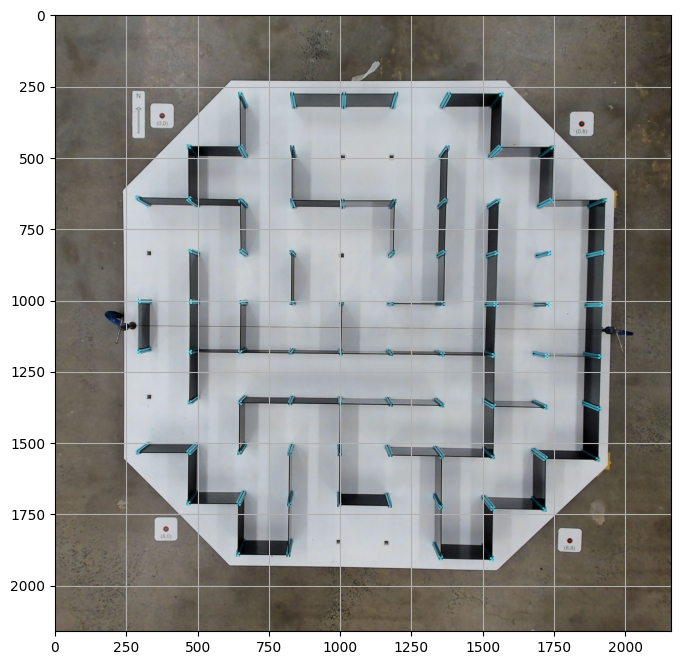

In [5]:
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 80
params.maxThreshold = 255

params.filterByArea = True
params.minArea = 30

params.filterByCircularity = True
params.minCircularity = 0.9

params.filterByConvexity = True
params.minConvexity = 0.87

params.filterByInertia = True
params.minInertiaRatio = 0.01

circle_detector = cv2.SimpleBlobDetector_create(params)
circ_keypoints = circle_detector.detect(map_image)

image_anno = map_image.copy()
image_anno = cv2.drawKeypoints(map_image, circ_keypoints, np.array([]), (255, 0, 0),
                               cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

points = [(int(keypoint.pt[0]), int(keypoint.pt[1]))
          for keypoint in circ_keypoints]

print(points)
for keypoint in points:
    cv2.circle(image_anno, keypoint, 1, (0, 255, 0), -1)

plt.figure(figsize=(8, 8))
plt.grid(True)
plt.imshow(image_anno)
plt.show()

## Wall Mask

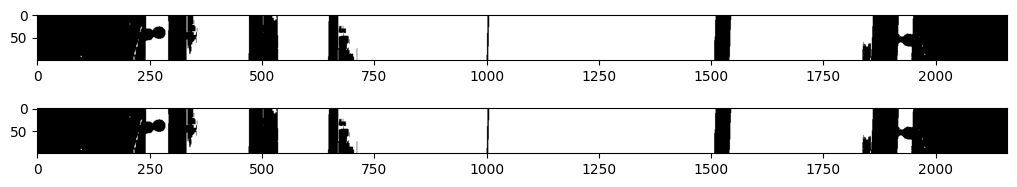

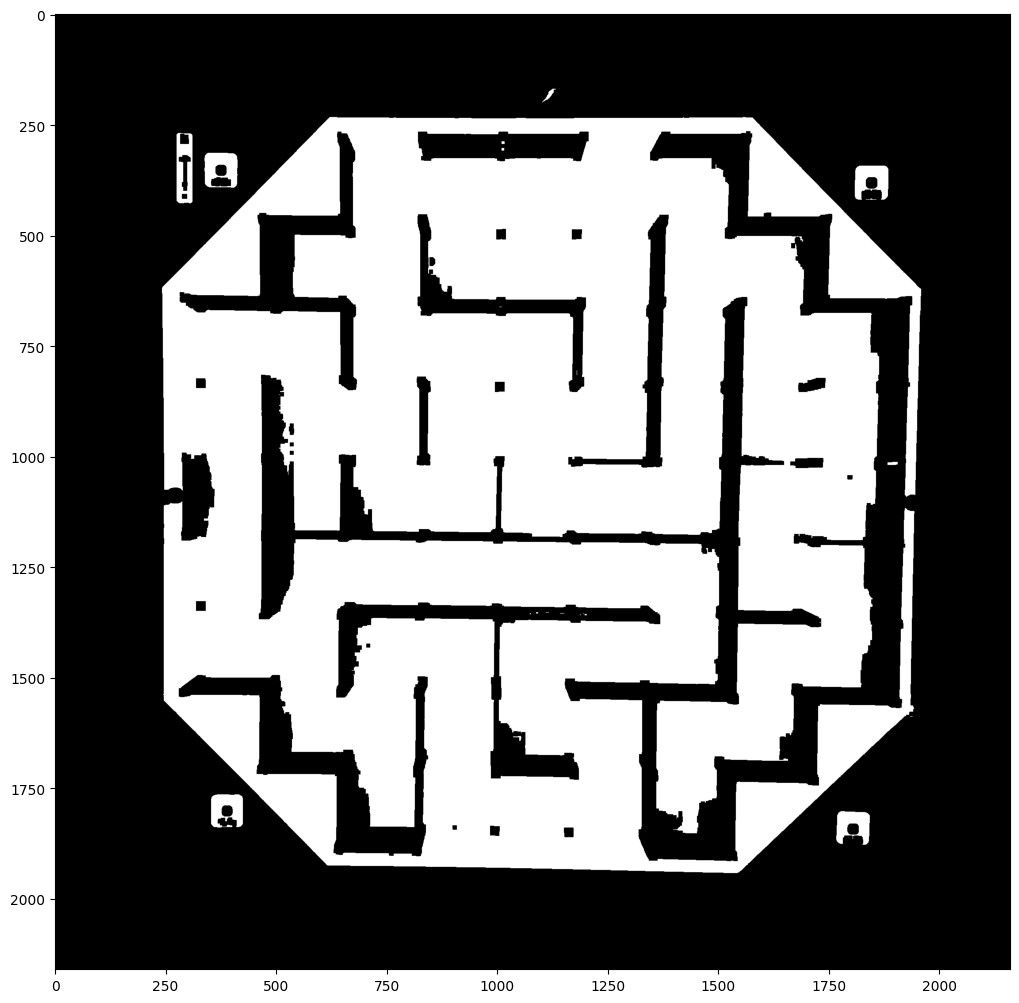

In [6]:
map_hsv = cv2.cvtColor(map_image, cv2.COLOR_RGB2HSV)

_, _, v = cv2.split(map_hsv)
_, mask_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

if map_image.shape[0] == 1080:
    connect_region = mask_v[520:560, :]
    pass
elif map_image.shape[0] == 2160:
    connect_region = mask_v[1050:1150, :]
kk = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
connect_region1 = cv2.morphologyEx(connect_region, cv2.MORPH_CLOSE, kk, iterations=2)

if map_image.shape[0] == 1080:
    mask_v[520:560, :] = connect_region1.copy()
    pass
elif map_image.shape[0] == 2160:
    mask_v[1050:1150, :] = connect_region1.copy()

k_size = 7
iter_n = 3

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_size, k_size))
wall_mask = cv2.morphologyEx(mask_v, cv2.MORPH_OPEN, kernel, iterations=iter_n)
wall_mask = cv2.morphologyEx(mask_v, cv2.MORPH_ERODE, np.ones((5, 5)), iterations=2)
# wall_mask = cv2.morphologyEx(wall_mask, cv2.MORPH_CLOSE, np.ones((3, 3)), iterations=1)


plt.figure(figsize=(10, 2))
plt.subplot(2, 1, 1)
plt.imshow(connect_region, cmap="gray")
plt.subplot(2, 1, 2)
plt.imshow(connect_region1, cmap="gray")
plt.tight_layout(pad=0.1)
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(wall_mask, cmap="gray")
plt.tight_layout(pad=0.1)
plt.show()

# Grid Creation

## Fixing Variables

In [7]:
from enum import IntEnum, auto
from typing import NamedTuple


class Direction(IntEnum):
    NORTH = auto()
    WEST = auto()
    SOUTH = auto()
    EAST = auto()


class Pose(NamedTuple):
    cell_x: int
    cell_y: int
    facing: Direction


grid_n = 9
outside = [
    (0, 0), (0, 1), (1, 0), (0, 8),
    (0, 7), (1, 8), (8, 0), (7, 0),
    (8, 1), (8, 8), (8, 7), (7, 8),
]

candidates = [(a, b) for a, b in itertools.product(range(9), range(9)) if (a, b) not in outside]
start_pose = Pose(*random.choice(candidates), random.choice([e for e in Direction]))
end_pose = Pose(*random.choice(candidates), random.choice([e for e in Direction]))

## Data Types

In [8]:
from collections import defaultdict, deque
from collections.abc import Callable
from typing import Dict, List, Optional, Tuple


class OutOfBoundException(Exception):
    pass


class Vertex:
    def __init__(self, vertex_id: int, x: int, y: int):
        self._id = vertex_id
        self._x = x
        self._y = y

    def get_point(self) -> Tuple[int, int]:
        return (self._x, self._y)

    @property
    def id(self) -> int:
        return self._id

    @property
    def x(self) -> int:
        return self._x

    @property
    def y(self) -> int:
        return self._y

    @x.setter
    def x(self, value: int):
        self._x = value

    @y.setter
    def y(self, value: int):
        self._y = value

    def __hash__(self) -> int:
        return hash(self.id)

    def __eq__(self, other):
        if not isinstance(other, Vertex):
            return False
        return self.id == other.id

    def __repr__(self):
        return f"Vertex(id={self.id}, x={self.x}, y={self.y})"

# Node implementation for Tree


class Node(Vertex):
    def __init__(self,
                 node_id: int,
                 x: int,
                 y: int,
                 parent: Optional["Node"] = None,
                 cost: float = 0.0):
        super().__init__(node_id, x, y)
        self._parent = parent
        self._cost = cost  # cost from parent to this node

    @property
    def cost(self) -> float:
        """The cost between this node and the parent node"""
        return self._cost

    @cost.setter
    def cost(self, c: float):
        self._cost = c

    @property
    def parent(self) -> Optional["Node"]:
        """
        Get thie nodes parent \n
        Returns: `Node` if this is not a root node, `None` otherwise
        """
        return self._parent

    @parent.setter
    def parent(self, parent: Optional["Node"]):
        self._parent = parent

    def __repr__(self) -> str:
        return f"Node(id={self.id}, x={self.x}, y={self.y}, link={self.parent.id if self.parent else None})"


# Tree class implementation for RRT/RRT*
class Tree:
    def __init__(self, root: Node):
        self._nodes: Dict[int, Node] = defaultdict(Node)
        self._root_cost: Dict[int, float] = defaultdict(float)
        self._nodes[root.id] = root
        self._root_cost[root.id] = 0  # cost from root to this node

    def add_node(self, node_id: int, x: float, y: float, parent: Node, cost: float):
        self._nodes[node_id] = Node(node_id, x, y, parent=parent, cost=cost)

    def get_node(self, idx: int) -> Optional[Node]:
        if idx not in self._nodes.keys():
            return None
        return self._nodes[idx]

    def get_nodes(self) -> List[Node]:
        return list(self._nodes.values())

    def get_cost_to_root(self, index: int):
        return self._root_cost[index]

    def nearest_neighbour(self, x: int, y: int) -> Tuple[int, float]:
        """
        P.S.: could possibliy call `Tree().get_neighbours_in_radius()` but have
        high space complexity when the search space is large
        """
        min_dist = float('inf')
        node_id = None
        for node in self._nodes.values():
            dist = math.hypot(node.x - x, node.y - y)
            if dist < min_dist:
                node_id = node.id
                min_dist = dist

        return node_id, min_dist

    def get_neighbours_in_radius(self, x: int, y: int, radius: float):
        """
        Get all neighbours in the tree that is within `radius` of the target location
        """
        return (v.id for v in self._nodes.values() if 2 < math.hypot(v.x - x, v.y - y) <= radius)

    def update(self, q_new_index: int, search_radius: float, collision_predicate: Callable[..., bool]):

        q_new = self.get_node(q_new_index)
        q_min = q_new.parent
        # root_cost(parent) + distance(q_near, q_new)
        c_min = self._root_cost[q_new.parent.id] + q_new.cost
        # find q_best
        for near_idx in self.get_neighbours_in_radius(*q_new.get_point(), search_radius):
            q_next = self.get_node(near_idx)
            if not collision_predicate(q_next.get_point(), q_new.get_point()):
                continue
            if q_next == q_new.parent:
                continue
            # cost from this q_test to root
            q_next_cost = self._root_cost[near_idx]
            q_distance = math.hypot(q_next.x - q_new.x, q_next.y - q_new.y)
            if q_next_cost + q_distance < c_min:
                q_min = q_next
                c_min = q_next_cost + q_distance
        q_new.parent = q_min
        # dist(q_near, q_min) = c_min - root_cost(q_min)
        q_new.cost = c_min - self._root_cost[q_min.id]
        self._root_cost[q_new.id] = c_min

        # relink part
        for near_idx in self.get_neighbours_in_radius(*q_new.get_point(), search_radius):
            q_next = self.get_node(near_idx)
            if not collision_predicate(q_next.get_point(), q_new.get_point()):
                continue
            # if this route has lower cost then the previous one?
            connect_cost = c_min
            q_distance = math.hypot(q_next.x - q_new.x, q_next.y - q_new.y)
            if connect_cost + q_distance < self._root_cost[near_idx]:
                q_next.parent = q_new
                q_next.cost = q_distance
                self._root_cost[q_next.id] = connect_cost + q_distance
                self.__update_nested(q_next)

    def __update_nested(self, node: Node):
        for child in self.get_nodes():
            if child.parent == node:
                # cost to parent + cost from root to parent
                self._root_cost[child.id] = child.cost + \
                    self._root_cost[node.id]
                self.__update_nested(child)

    def path_to_root(self, index: int) -> List[int]:
        path = []
        node = self.get_node(index)
        while node is not None:
            path.append(node.id)
            node = node.parent
        return path[::-1]

# Graph Implementation


class Graph:
    def __init__(self):
        self._vertices: Dict[int, Vertex] = defaultdict(
            Vertex)  # Dict[int, Vertex]
        self._edges: Dict[int, List[Tuple[int, float]]] = defaultdict(list)

    def add_vertex(self, vertex_id: int, x: float, y: float):
        if vertex_id in self._vertices:
            self._vertices.pop(vertex_id)
        self._vertices[vertex_id] = Vertex(vertex_id, x, y)

    def add_edge(self, start: int, end: int, cost: float = 1.0, directed: bool = False):
        if start not in self._vertices:
            raise OutOfBoundException(f"Vertex {start} not found!")
        elif end not in self._vertices:
            raise OutOfBoundException(f"Vertex {end} not found!")

        self._edges[start] = [(neighbor, w) for neighbor,
                              w in self._edges[start] if neighbor != end]
        self._edges[start].append((end, cost))
        if not directed:
            self._edges[end] = [(neighbor, w) for neighbor,
                                w in self._edges[end] if neighbor != start]
            self._edges[end].append((start, cost))

    def remove_edge(self, start_id, end_id):
        if start_id not in self._edges and end_id not in self._edges:
            raise OutOfBoundException(
                f"Edege ({start_id}) -- ({end_id}) does not exist")

        self._edges[start_id] = [(neighbor, w) for neighbor,
                                 w in self._edges[start_id] if neighbor != end_id]
        self._edges[end_id] = [(neighbor, w) for neighbor,
                               w in self._edges[end_id] if neighbor != start_id]

    def get_vertices(self) -> List[Vertex]:
        return sorted(list(self._vertices.values()), key=lambda v: v.id)

    def get_vertex(self, node_id: int) -> Vertex:
        if node_id not in self._vertices:
            return None
        return self._vertices[node_id]

    def get_edges(self) -> Dict[int, Tuple[int, float]]:
        return self._edges

    def get_connections(self, source_vertex_id: int) -> List[Tuple[int, float]]:
        if source_vertex_id not in self._edges:
            return list()
        else:
            return self._edges[source_vertex_id]

    def get_edge_cost(self, _from_id: int, _to_id: int):
        neighbours = self._edges[_from_id]
        for neighbour, cost in neighbours:
            if _to_id == neighbour:
                return cost
        return None

## Utility Functions

In [9]:
def path_clear(image: cv2.Mat, p1: Tuple[int, int], p2: Tuple[int, int]) -> bool:
    """
    Given a pair of points in (x, y)\n
    this function check if this two points have clear path between them
    """

    x1, y1 = p1
    x2, y2 = p2
    dx = abs(x2 - x1)
    sx = 1 if x1 < x2 else -1
    dy = -abs(y2 - y1)
    sy = 1 if y1 < y2 else -1
    error = dx + dy

    while True:
        if image[y1, x1] != 255:
            # print(f"{(x1, y1)} is {image[y1, x1]}")
            return False
        e2 = 2 * error
        if e2 >= dy:
            if x1 == x2:
                break
            error += dy
            x1 += sx
        if e2 <= dx:
            if y1 == y2:
                break
            error += dx
            y1 += sy
    return True


def cell_to_index(cell_x: int, cell_y: int, grid_size: int) -> int:
    if 0 <= cell_x < grid_size and 0 <= cell_y < grid_size:
        # cell_y is j-indexed, cell_x is i-indexed
        return cell_x * grid_size + cell_y
    else:
        raise OutOfBoundException(
            rf"Cell {(cell_x, cell_y)} specified while maximum label is {(grid_size, grid_size)}")


def get_cell(graph: Graph, cell_x: int, cell_y: int, grid_size: int):
    # cell_y is j-indexed, cell_x is i-indexed
    return graph.get_vertex(cell_to_index(cell_x, cell_y, grid_size))


def index_to_cell(index: int, grid_size: int) -> int:
    return divmod(index, grid_size)

## Convention

The Cell Labels have the following convention:
| Axes | Direction | Image Index  |  Cell Label |
| ---- | --------- | ------------ | ----------- |
|  x+  |   East    | image[x+, :] |  (:, **o**) |
|  x-  |   West    | image[x-, :] |  (:, **o**) |
|  y+  |   North   | image[:, y+] |  (**o** ,:) |
|  y-  |   South   | image[:, y-] |  (**o** ,:) |


This means that:
- `(0, 0)` refers to the top left cell
- `(8, 8)` refers to the bottom right cell.
- `(4, 6)` refers to the cell at row #4 and col #6

[(375, 366), (1846, 366), (388, 1822), (1804, 1822)]


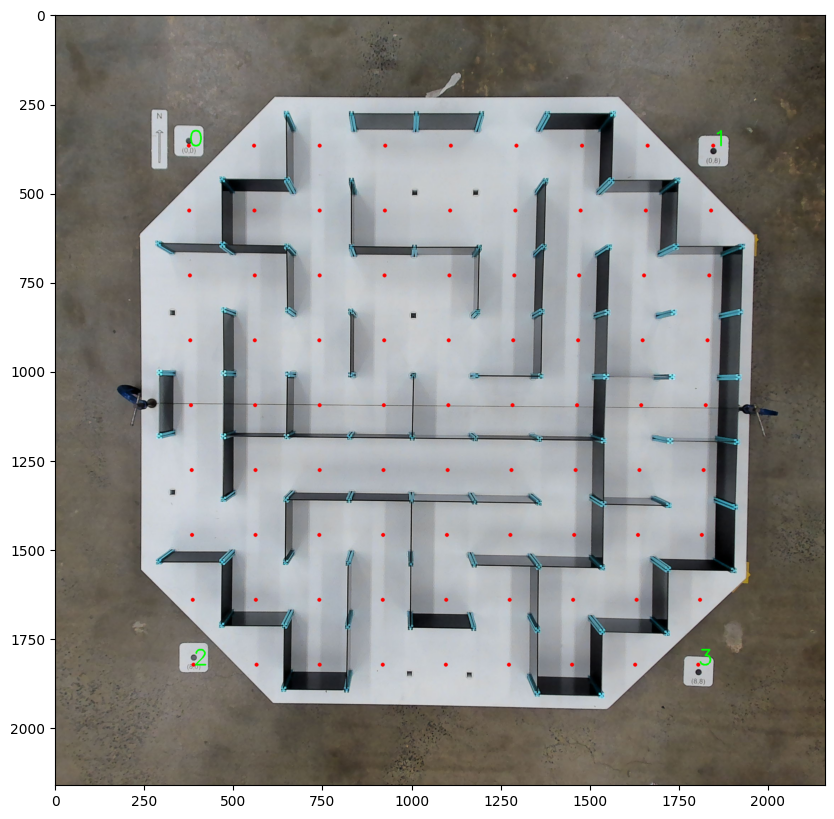

In [10]:
map_anno = map_image.copy()

points = sorted(points, key=lambda t: (t[1], t[0]))
y_top = 0.5 * (points[0][1] + points[1][1])
y_bot = 0.5 * (points[2][1] + points[3][1])
points[0] = (points[0][0], int(y_top))
points[1] = (points[1][0], int(y_top))
points[2] = (points[2][0], int(y_bot))
points[3] = (points[3][0], int(y_bot))
print(points)

xy_top = [  # p0 -> p1
    (x, y)
    for x, y in zip(
        np.linspace(points[0][0], points[1][0], num=grid_n, dtype=int),
        np.linspace(points[0][1], points[1][1], num=grid_n, dtype=int))
]

xy_bot = [  # p2 -> p3
    (x, y)
    for x, y in zip(
        np.linspace(points[2][0], points[3][0], num=grid_n, dtype=int),
        np.linspace(points[2][1], points[3][1], num=grid_n, dtype=int))
]

xy_left = [  # p0 -> p2
    (x, y)
    for x, y in zip(
        np.linspace(points[0][0], points[2][0], num=grid_n, dtype=int),
        np.linspace(points[0][1], points[2][1], num=grid_n, dtype=int)
    )
]

xy_right = [  # p1 -> p3
    (x, y)
    for x, y in zip(
        np.linspace(points[1][0], points[3][0], num=grid_n, dtype=int),
        np.linspace(points[1][1], points[3][1], num=grid_n, dtype=int)
    )
]

for (xl, yl), (xr, yr) in zip(xy_left, xy_right):
    # cv2.line(map_anno, (xl, yl), (xr, yr), (0, 0, 127), 5, cv2.LINE_AA)
    xx = np.linspace(xl, xr, grid_n, dtype=int)
    yy = np.linspace(yl, yr, grid_n, dtype=int)
    for xi, yi in zip(xx, yy):
        cv2.circle(map_anno, (xi, yi), 5, (255, 0, 0), -1, cv2.LINE_AA)
    pass


for index, p in enumerate(points):
    cv2.putText(map_anno, f"{index}", p,
                cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)


plt.figure(figsize=(10, 10))
plt.imshow(map_anno)
plt.show()

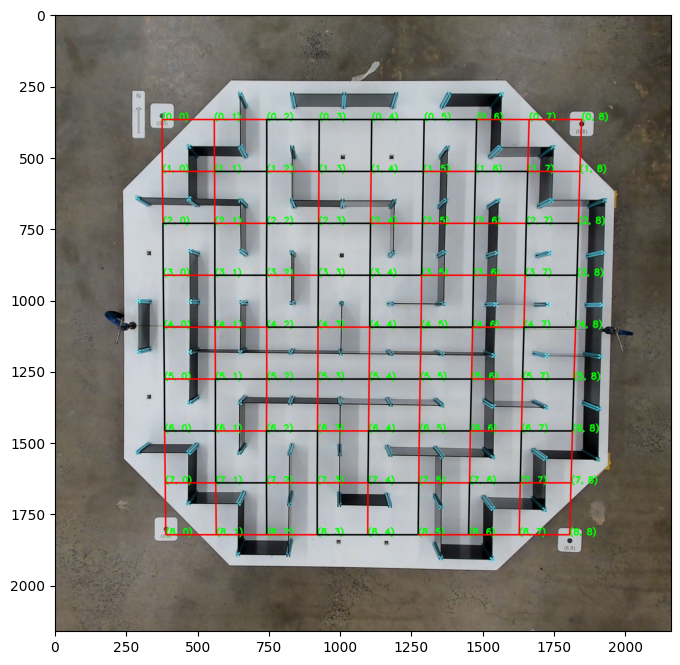

In [11]:
map_marker = map_image.copy()

maze_graph = Graph()

for x_idx, ((xl, yl), (xr, yr)) in enumerate(zip(xy_left, xy_right)):
    xx = np.linspace(xl, xr, grid_n, dtype=int)
    yy = np.linspace(yl, yr, grid_n, dtype=int)
    for y_idx, (xi, yi) in enumerate(zip(xx, yy)):
        maze_graph.add_vertex(grid_n * x_idx + y_idx, xi, yi)
        cv2.putText(map_marker, f"{(x_idx, y_idx)}", (xi, yi),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
    pass


# print(*maze_graph.get_vertices())

neighbours = [
    (0, 1),  # x+1, 0
    (1, 0),  # 0, y+1
]

# here we use raycasting to check
# if a cell is traversable from its adjacent cell
for x_idx in range(grid_n):
    for y_idx in range(grid_n):
        my_cell = get_cell(maze_graph, x_idx, y_idx, grid_n)
        for dx, dy in neighbours:
            nx, ny = x_idx + dx, y_idx + dy
            if nx >= grid_n or ny >= grid_n:
                continue
            that_cell = get_cell(maze_graph, nx, ny, grid_n)

            if path_clear(wall_mask, my_cell.get_point(), that_cell.get_point()):
                maze_graph.add_edge(my_cell.id, that_cell.id, 1)
                cv2.line(map_marker, my_cell.get_point(),
                         that_cell.get_point(), (0, 0, 0), 3, cv2.LINE_AA)
                pass
            else:
                cv2.line(map_marker, my_cell.get_point(),
                         that_cell.get_point(), (255, 0, 0), 3, cv2.LINE_AA)
                pass


plt.figure(figsize=(8, 8))
plt.imshow(map_marker)
plt.show()

# Map Creator

## Fixing Variables

In [12]:
ppcm = 10  # pixels per cm
ppmm = ppcm / 10 # pixels per mm
cell_size = round(18 * ppcm)  # cm to pixels
wall_size = round(0.8 * ppcm)  # cm to pixels
pillar_size = round(4 * ppcm)  # cm to pixels
grid_size = wall_size + cell_size

W = H = grid_n * cell_size + (grid_n + 1) * wall_size
print(f"Canvas Size: {(W, H)}")

wall_offset = [
    ((0, 0), (0, 1)),
    ((0, 0), (1, 0)),
    ((0, 1), (1, 1)),
    ((1, 0), (1, 1)),
]

outside = [
    (0, 0), (0, 1),
    (1, 0), (0, 8),
    (0, 7), (1, 8),
    (8, 0), (7, 0),
    (8, 1), (8, 8),
    (8, 7), (7, 8),
]

pillar_outside = [
    (0, 0), (0, 1),
    (1, 0), (0, 8),
    (8, 0),
    (0, 9), (9, 0),
    (1, 9), (9, 1),
    (8, 9), (9, 9),
    (9, 8)
]

Canvas Size: (1700, 1700)


## Map Image to New Canvas

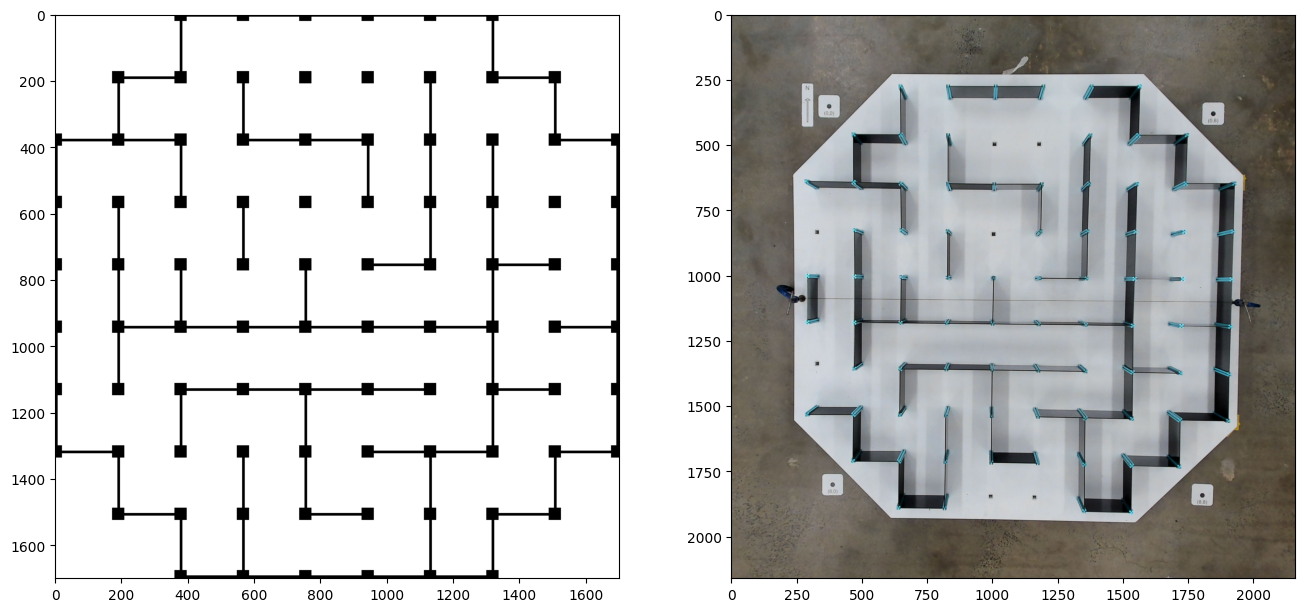

In [13]:
costmap = np.zeros((W, H), dtype=np.uint8) * 255

for vertex in maze_graph.get_vertices():
    connections = maze_graph.get_connections(vertex.id)
    y, x = index_to_cell(vertex.id, grid_n)  # get index
    if (y, x) in outside:
        continue
    cv2.rectangle(costmap, (x * grid_size, y * grid_size), ((x+1) * grid_size +
                  wall_size - 1, y * grid_size + wall_size - 1), 255, -1)  # top wall
    cv2.rectangle(costmap, (x * grid_size, (y + 1) * grid_size), ((x+1) * grid_size +
                  wall_size - 1, (y + 1) * grid_size + wall_size - 1), 255, -1)  # bot wall

    cv2.rectangle(costmap, (x * grid_size, y * grid_size), (x * grid_size +
                  wall_size - 1, (y + 1) * grid_size + wall_size - 1), 255, -1)  # left wall
    cv2.rectangle(costmap, ((x+1) * grid_size, y * grid_size), ((x+1) * grid_size +
                  wall_size - 1, (y + 1) * grid_size + wall_size - 1), 255, -1)  # right wall

    for conn, cost in connections:
        ny, nx = index_to_cell(conn, grid_n)
        dd = (y - ny, x - nx)
        # since we are checking connectivity
        # here we remove wall instead
        if dd == (-1, 0):  # goes down
            cv2.rectangle(costmap, (x * grid_size + wall_size, (y + 1) * grid_size), ((
                x+1) * grid_size - 1, (y + 1) * grid_size + wall_size - 1), 0, -1)  # bot wall
            # print("Removing wall")
        if dd == (1, 0):  # goes up
            cv2.rectangle(costmap, (x * grid_size + wall_size, y * grid_size),
                          ((x+1) * grid_size - 1, y * grid_size + wall_size - 1), 0, -1)  # top wall
            pass
        if dd == (0, 1):  # goes left
            cv2.rectangle(costmap, (x * grid_size, y * grid_size + wall_size), (x *
                          grid_size + wall_size - 1, (y + 1) * grid_size - 1), 0, -1)  # left wall
            pass
        if dd == (0, -1):  # goes right
            cv2.rectangle(costmap, ((x+1) * grid_size, y * grid_size + wall_size), ((x+1)
                          * grid_size + wall_size - 1, (y + 1) * grid_size - 1), 0, -1)  # right wall
            pass

# finally we draw out the pillars
for i in range(grid_n + 1):
    for j in range(grid_n + 1):
        if (i, j) in pillar_outside:
            continue
        cv2.rectangle(costmap, (i * grid_size - (pillar_size - wall_size) // 2, j * grid_size - (pillar_size - wall_size) // 2),
                      (i * grid_size + (pillar_size) // 2, j * grid_size + (pillar_size) // 2), 255, -1)

costmap = ~costmap


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(costmap, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(map_image)
plt.show()

## Inflat to Create Costmap

52.0 80.0 0.1


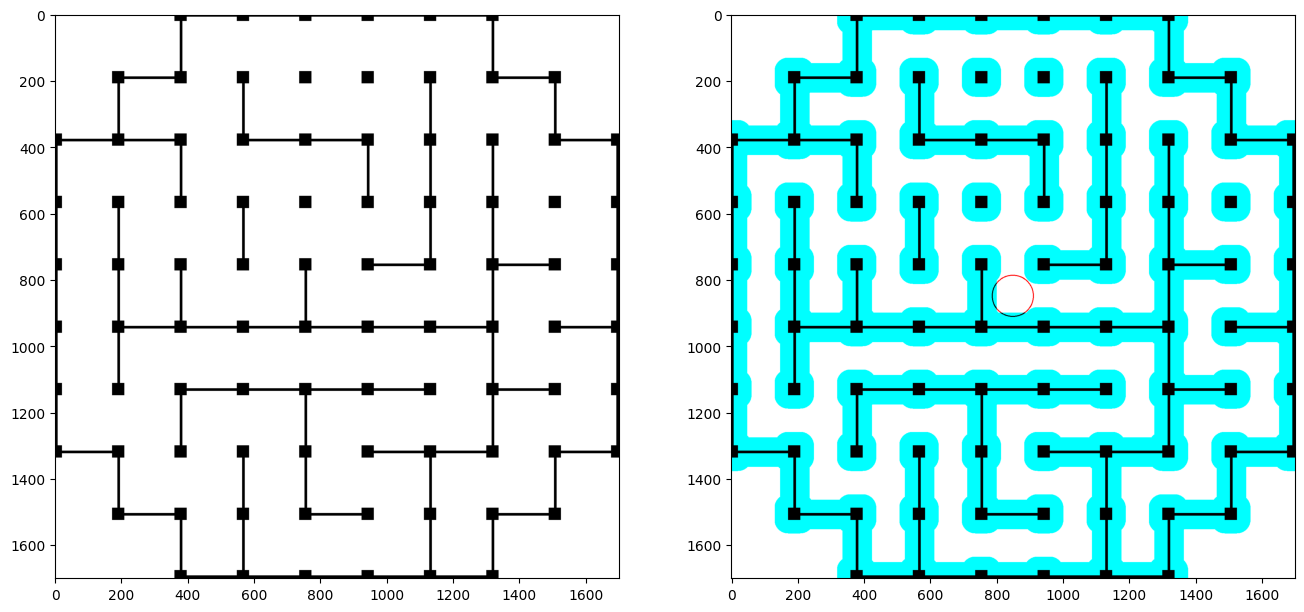

In [14]:
def compute_inflation_costmap(occupancy_grid, resolution,
                              inflation_radius, inscribed_radius,
                              cost_obstacle=255, cost_free=0, rate=3.0):
    # obstacle_mask = 255 - occupancy_grid
    inflat_kernel_size = round(inflation_radius / resolution) + 2
    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (inflat_kernel_size, inflat_kernel_size))

    return cv2.erode(occupancy_grid, kernel)


# Parameters
inscribed_radius = 5.2  # mm
footprint_radius = 6.2  # mm
inflation_radius = 8.0  # mm
resolution = 18 / cell_size
print(inscribed_radius / resolution, inflation_radius / resolution, resolution)

inflated_costmap = compute_inflation_costmap(
    costmap, resolution=resolution,
    inflation_radius=inflation_radius,
    inscribed_radius=inscribed_radius
)

test_costmap = costmap.copy()
test_costmap = cv2.cvtColor(test_costmap, cv2.COLOR_GRAY2RGB)
cv2.circle(test_costmap, (4 * grid_size + wall_size - 1 + cell_size // 2, 
                          4 * grid_size + wall_size - 1 + cell_size // 2), 
                           int(footprint_radius / resolution), (255, 0, 0), 2)
test_costmap[:, :, 0] = inflated_costmap


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(costmap, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(test_costmap, cmap='gray')
plt.show()

# Solver

## Breath-First Search

In [15]:
from collections import deque


def bfs(graph, start_node_id: int, end_node_id: int):
    dq = deque()
    visited = set()

    # index = vertex ID, value = direct ancestor node ID
    parent = [-1] * len(graph.get_vertices())
    # index = vertex ID, value = cost from root to this node
    cost = [-1] * len(graph.get_vertices())
    path = []

    if (start_node_id == end_node_id):
        return [start_node_id]

    # build relationship
    visited.add(start_node_id)
    dq.append(start_node_id)
    cost[start_node_id] = 0
    while len(dq) > 0:
        v = dq.popleft()
        if v == end_node_id:
            break

        neighbours = [v for v, _ in graph.get_connections(
            v) if v not in visited]
        # print(f"Neighbours: {neighbours}")
        for nh in neighbours:
            visited.add(nh)
            dq.append(nh)
            parent[nh] = v  # w.parent = v
            cost[nh] = cost[v] + 1  # cost = c_parent + 1
        # print("-"*10)
        # print(dq)
        # print('='*10)

    if (cost[end_node_id] == -1):
        return list()  # does not exist

    # print(parent)

    # Find the path
    index = end_node_id
    while index != -1:
        path.append(index)
        index = parent[index]
    path.reverse()

    return path

## Asymptotically-Optimal RRT

In [16]:
def lerp(x_src: int, y_src: int, x: int, y: int, step_size: float) -> tuple[int, int, float]:
    dx = x - x_src
    dy = y - y_src
    distance = math.hypot(dx, dy)
    if distance <= step_size:
        return (x, y), distance

    # vector will be length 1
    nx = dx / distance
    ny = dy / distance

    new_x = round(x_src + step_size * nx)
    new_y = round(y_src + step_size * ny)
    return (new_x, new_y), float(step_size)


def build_rrt_star(image: np.array,
                   start: Pose,
                   end: Pose,
                   alpha: float = 0.1,
                   connect_radius: float = 200,
                   step_size: float = 40,
                   max_node_count: int = 500):
    # maximum attempts before failing
    max_iter = max_node_count * 2
    # created node count
    node_count = 0
    # how far a node is permitted to branch away from the tree
    advance_radius = float(step_size)

    cell_center_coord = [
        (x  * grid_size + wall_size + cell_size // 2, y * grid_size + wall_size + cell_size // 2)
        for (x, y) in itertools.product(range(grid_n), range(grid_n))
    ]

    # add start node
    tree = Tree(Node(-1, start.cell_x, start.cell_y))

    for _ in itertools.repeat(None, max_iter):
        # enough nodes created, exit
        if node_count >= max_node_count:
            break

        # q <- RAND_CONF(Q)
        if random.random() < alpha:
            target = (end.cell_x, end.cell_y)
        else:
            x = random.randint(0, image.shape[1] - 1)
            y = random.randint(0, image.shape[0] - 1)
            target = (x, y)

        for (cx, cy) in cell_center_coord:
            if math.hypot(target[0] - cx, target[1] - cy) <= 6 * ppcm:
                target, _ = lerp(*target, *(cx, cy),  3.5 * ppcm)
        
        if image[target[1], target[0]] != 255:
            continue

        # q_near <- nearest_neighbour(T, q)
        q_near, q_near_dist = tree.nearest_neighbour(*target)

        # check if this node is too close to other neighbours
        if q_near_dist <= float(step_size):
            continue

        q_near_xy = tree.get_node(q_near).get_point()
        q_new_xy, distance = lerp(*q_near_xy, *target, advance_radius)

        if not path_clear(image, q_near_xy, q_new_xy):
            continue

        # add the node first s.t. q_nearest <- d -> q_new
        tree.add_node(node_count, *q_new_xy, tree.get_node(q_near), distance)

        # then update the tree
        tree.update(node_count, connect_radius, lambda p1,
                    p2: path_clear(image, p1, p2))

        # check if newly placed branch could reach the goal in step_size length
        g_nearest = tree.get_node(node_count)
        g_dist = math.hypot(g_nearest.x - end.cell_x, g_nearest.y - end.cell_y)
        if g_dist <= float(step_size):
            tree.add_node(node_count + 1, end.cell_x, end.cell_y,
                          parent=g_nearest, cost=g_dist + g_nearest.cost)
            tree.update(node_count + 1, connect_radius,
                        lambda p1, p2: path_clear(image, p1, p2))
            return tree, node_count + 1  # directly exit since the path is solvable

        node_count += 1
    return tree, None

## Generate Commands

In [17]:
def sliding_window(iterable, n):
    "Collect data into overlapping fixed-length chunks or blocks."
    # sliding_window('ABCDEFG', 4) → ABCD BCDE CDEF DEFG
    iterator = iter(iterable)
    window = deque(itertools.islice(iterator, n - 1), maxlen=n)
    for x in iterator:
        window.append(x)
        yield tuple(window)


def generate_move_command(path: List[int], start_facing: Direction, end_facing: Direction):
    global grid_n
    avaliable_commands = ("F", "R", "L")
    radix = [divmod(p, grid_n) for p in path]

    d = {
        # diff(from_xy, to_xy)
        (1, 0): Direction.NORTH,
        (0, -1): Direction.EAST,
        (-1, 0): Direction.SOUTH,
        (0, 1): Direction.WEST
    }

    # command for movement pairs
    # (y1, y2, x1, x2)
    move_key = {
        # forward
        (1,  1, 0, 0): ("F", 0),
        (-1, -1, 0, 0): ("F", 0),
        (0, 0,  1,  1): ("F", 0),
        (0, 0, -1, -1): ("F", 0),

        # counter clockwise movement
        (0, -1, 1, 0): ("FL", 1),
        (-1, 0, 0, -1): ("FL", 1),
        (0, 1, -1, 0): ("FL", 1),
        (1, 0, 0, 1): ("FL", 1),

        # clockwise movement
        (1, 0, 0, -1): ("FR", -1),
        (0, 1, 1, 0): ("FR", -1),
        (-1, 0, 0, 1): ("FR", -1),
        (0, -1, -1, 0): ("FR", -1)
    }

    command = ""
    facing = start_facing

    p1, p2 = radix[0], radix[1]
    dx = p1[1] - p2[1]  # <-- -->
    dy = p1[0] - p2[0]  # order swapped due to orientation markerthe
    path_facing = d[(dy, dx)]
    diff = start_facing - path_facing

    if diff < 0:
        command += "L" * abs(diff)
    elif diff > 0:
        command += "R" * abs(diff)

    for s, m, e in sliding_window(radix, n=3):
        cc = ""
        dy1 = s[0] - m[0]
        dy2 = m[0] - e[0]
        dx1 = s[1] - m[1]
        dx2 = m[1] - e[1]

        cc, c = move_key[(dy1, dy2, dx1, dx2)]

        command += cc

    command += "F"

    return command

# Final Call

In [18]:
# start_pose = Pose(*random.choice(candidates), random.choice([e for e in Direction]))
# end_pose = Pose(*random.choice(candidates), random.choice([e for e in Direction]))
start_pose = Pose(8, 6, Direction.SOUTH)
end_pose = Pose(7, 5, Direction.SOUTH)
rrt_start_cell = Pose(
    start_pose.cell_y * grid_size + wall_size + cell_size // 2,
    start_pose.cell_x * grid_size + wall_size + cell_size // 2,
    start_pose.facing
)

rrt_goal_cell = Pose(
    end_pose.cell_y * grid_size + wall_size + cell_size // 2,
    end_pose.cell_x * grid_size + wall_size + cell_size // 2,
    end_pose.facing
)

Start: (8, 6, 'SOUTH') -> End: (7, 5)
Path (cell)
{8, 6}, {7, 6}, {7, 7}, {6, 7}, {6, 8}, {5, 8}, {5, 7}, {4, 7}, {4, 8}, {3, 8}, {2, 8}, {2, 7}, {1, 7}, {1, 6}, {0, 6}, {0, 5}, {0, 4}, {0, 3}, {0, 2}, {1, 2}, {2, 2}, {3, 2}, {3, 1}, {2, 1}, {2, 0}, {3, 0}, {4, 0}, {5, 0}, {6, 0}, {6, 1}, {7, 1}, {7, 2}, {6, 2}, {6, 3}, {7, 3}, {8, 3}, {8, 4}, {8, 5}, {7, 5}, Actions: "RRFRFLFRFLFLFRFRFLFFLFRFLFRFLFFFFLFFFRFRFLFLFFFFLFRFLFLFRFRFFLFFLF"


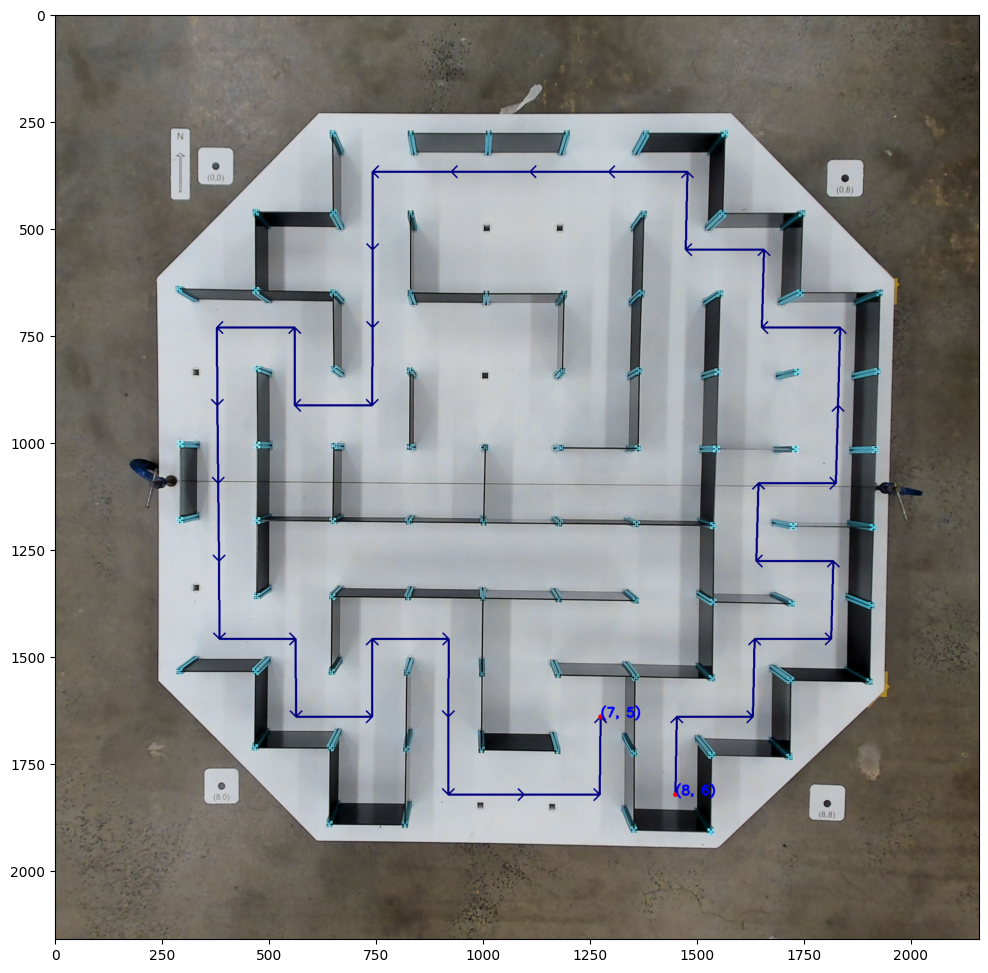

In [19]:
path_image = map_image.copy()

# now try searching
path_bfs = bfs(maze_graph,
               cell_to_index(start_pose.cell_x, start_pose.cell_y, grid_n),
               cell_to_index(end_pose.cell_x, end_pose.cell_y, grid_n)
               )


for v1, v2 in itertools.pairwise(path_bfs):
    p1 = maze_graph.get_vertex(v1).get_point()
    p2 = maze_graph.get_vertex(v2).get_point()
    cv2.arrowedLine(path_image, p1, p2, (0, 0, 128), 3)

move_commands = generate_move_command(
    path_bfs, start_pose.facing, end_pose.facing)

cv2.circle(path_image, maze_graph.get_vertex(
    path_bfs[0]).get_point(), 5, (255, 0, 0), -1, cv2.LINE_AA)
cv2.circle(path_image, maze_graph.get_vertex(
    path_bfs[-1]).get_point(), 5, (255, 0, 0), -1, cv2.LINE_AA)
cv2.putText(path_image, f"{(start_pose.cell_x, start_pose.cell_y)}", maze_graph.get_vertex(path_bfs[0]).get_point(),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
cv2.putText(path_image, f"{(end_pose.cell_x, end_pose.cell_y)}", maze_graph.get_vertex(path_bfs[-1]).get_point(),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
# cv2.arrowedLine(path_image, )

# Display the resulting image
print(f"Start: {(start_pose.cell_x, start_pose.cell_y, start_pose.facing.name)} -> End: {(end_pose.cell_x, end_pose.cell_y)}")
print("Path (cell)")
for idx in path_bfs:
    x, y = index_to_cell(idx, grid_n)
    print(f"{{{x}, {y}}}", end=', ')
# print(f"Path (cell): {[f"{{index_to_cell(idx, grid_n)}\}" for idx in path_bfs]}")
# print(f"Path (mm): ", end="")
# print(*list(map(lambda t: (int(t[0]), int(t[1])), [maze_graph.get_vertex(p).get_point() for p in path_bfs])), sep=", ")
print(f"Actions: \"{move_commands}\"")
plt.figure(figsize=(12, 12))
plt.imshow(path_image)
plt.show()

Start: (1226, 1602, 'SOUTH') -> End: (1038, 1414)
Path: (1226, 1602) -> (1246, 1470) -> (1325, 1393) -> (1414, 1339) -> (1441, 1255) -> (1536, 1208) -> (1593, 1132) -> (1581, 1089) -> (1430, 988) -> (1444, 853) -> (1540, 831) -> (1569, 796) -> (1573, 751) -> (1579, 706) -> (1454, 611) -> (1412, 552) -> (1415, 474) -> (1376, 339) -> (1249, 222) -> (1213, 156) -> (1135, 105) -> (966, 116) -> (774, 99) -> (649, 111) -> (504, 121) -> (501, 166) -> (482, 339) -> (477, 384) -> (476, 429) -> (460, 589) -> (457, 634) -> (294, 621) -> (275, 540) -> (208, 493) -> (164, 485) -> (95, 574) -> (95, 707) -> (92, 752) -> (95, 797) -> (91, 842) -> (92, 887) -> (90, 932) -> (88, 977) -> (94, 1022) -> (114, 1181) -> (155, 1199) -> (280, 1297) -> (278, 1342) -> (397, 1415) -> (474, 1326) -> (558, 1215) -> (675, 1322) -> (669, 1367) -> (676, 1554) -> (839, 1590) -> (983, 1586) -> (1047, 1487) -> (1038, 1414)
Cost: 5802.90479314667
Coordinate Mapping: (cm, cm)
WP_X: [1218.0, 1238.0, 1317.0, 1406.0, 1433.0, 

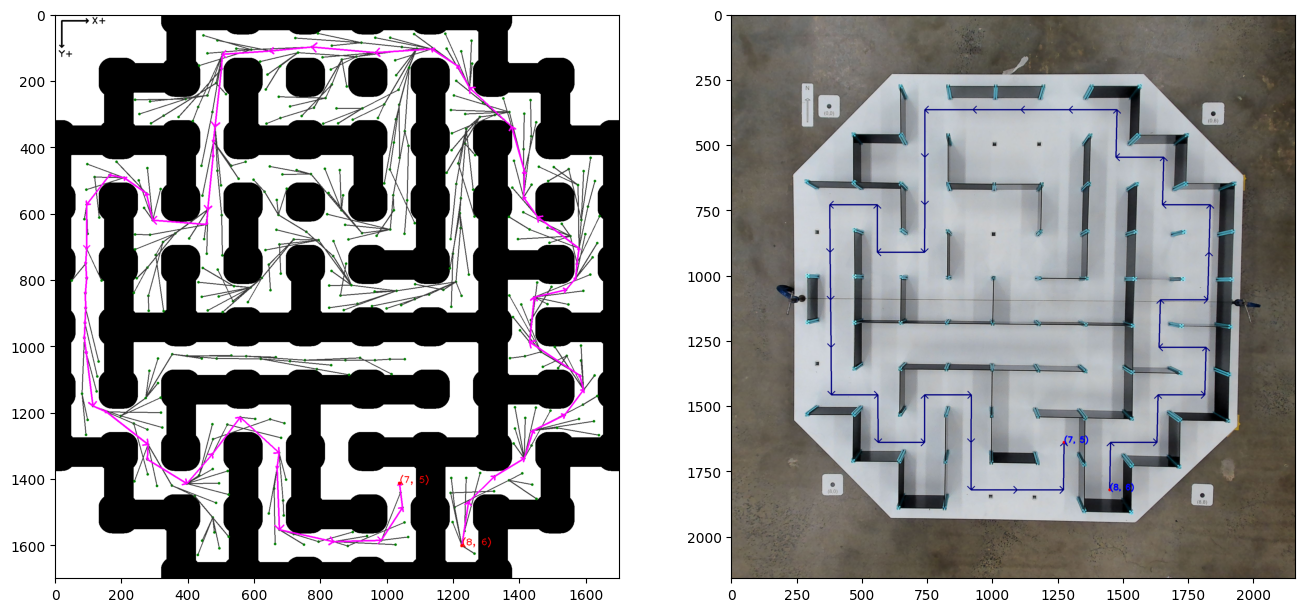

In [20]:
max_node_count = 10_000_000

rrt_image = cv2.cvtColor(inflated_costmap.copy(), cv2.COLOR_GRAY2RGB)
rrt_tree, goal_index = build_rrt_star(inflated_costmap, rrt_start_cell, rrt_goal_cell,
                                      alpha=.4,
                                      step_size=4.5 * ppcm,
                                      max_node_count=max_node_count)

# print(rrt_tree.get_nodes())
for v in rrt_tree.get_nodes():
    p = v.parent
    if p is not None:
        cv2.line(rrt_image, v.get_point(), p.get_point(), (60, 60, 60), 2)
    cv2.circle(rrt_image, v.get_point(), 4, (0, 128, 0), -1)

path = rrt_tree.path_to_root(goal_index)

for idx_1, idx_2 in itertools.pairwise(path + [path[-1]]):
    n1 = rrt_tree.get_node(idx_1)
    n2 = rrt_tree.get_node(idx_2)
    cv2.arrowedLine(rrt_image, n1.get_point(), n2.get_point(), (255, 0, 255), 3)

cv2.circle(rrt_image, (rrt_start_cell.cell_x, rrt_start_cell.cell_y),
           5, (255, 0, 0), -1, cv2.LINE_8)
cv2.circle(rrt_image, (rrt_goal_cell.cell_x, rrt_goal_cell.cell_y),
           5, (255, 0, 0), -1, cv2.LINE_8)

cv2.putText(rrt_image, f"{(start_pose.cell_x, start_pose.cell_y)}", rrt_tree.get_node(path[0]).get_point(), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
cv2.putText(rrt_image, f"{(end_pose.cell_x, end_pose.cell_y)}", rrt_tree.get_node(path[-1]).get_point(), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)


cv2.arrowedLine(rrt_image, (20, 20), (100, 20), (0, 0, 0), 3)
cv2.putText(rrt_image, f"X+", (110, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 2)
cv2.arrowedLine(rrt_image, (20, 20), (20, 100), (0, 0, 0), 3)
cv2.putText(rrt_image, f"Y+", (10, 130), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 2)

print(f"Start: {(rrt_start_cell.cell_x, rrt_start_cell.cell_y, start_pose.facing.name)} -> End: {(rrt_goal_cell.cell_x, rrt_goal_cell.cell_y)}")
print("Path:", "", end="")
print(*[rrt_tree.get_node(p).get_point() for p in path], sep=" -> ")
print("Cost:", rrt_tree.get_cost_to_root(goal_index))

wp_x = list()
wp_y = list()
for p in path:
    x, y = rrt_tree.get_node(p).get_point()
    wp_x.append((x - wall_size) / ppcm * 10)
    wp_y.append((y - wall_size) / ppcm * 10)

print("Coordinate Mapping: (cm, cm)")
print("WP_X:", wp_x)
print("WP_Y:", wp_y)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(rrt_image)
plt.subplot(1, 2, 2)
plt.imshow(path_image)
plt.show()